# Predicting Business Popularity
##### Pytorch Geometric implementation with NetworkX graph

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn

import networkx as nx
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating the network graph datasets

We use NetworkX to read and parse the graph into train/validate/test sets. We load these into DataLoader to use mini-batching.

In [ ]:
G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurants_test1.gpickle")

In [ ]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 29963
Number of edges: 491371


In [ ]:
H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

In [ ]:
print(dataset.graphs[0])

Graph(G=[], edge_index=[2, 982742], edge_label_index=[2, 982742], node_feature=[29963, 537], node_label=[29963], node_label_index=[29963], node_type=[29963], task=[])


In [ ]:
dataset.graphs[0].node_label = torch.LongTensor(dataset.graphs[0].node_label)
print(dataset.graphs[0].node_label)

tensor([2, 2, 1,  ..., 2, 2, 1])


In [ ]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

There are 537 features and 3 labels.


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the popularity category, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_node_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=537, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
x = dataset.graphs[0].node_feature
y = dataset.graphs[0].node_label

print(x.size())
print(y.size())

torch.Size([29963, 537])
torch.Size([29963])


In [ ]:
import numpy as np

mask = np.random.rand(1, y.size()[0])

train_mask = (mask < 0.9)[0]
test_mask = (mask >= 0.9)[0]

print(train_mask)
print(test_mask)

[ True False  True ...  True  True  True]
[False  True False ... False False False]


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(x)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 500):
    loss = train()
    if epoch % 5 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 005, Loss: 1.0353
Epoch: 010, Loss: 0.9847
Epoch: 015, Loss: 0.9554
Epoch: 020, Loss: 0.9334
Epoch: 025, Loss: 0.9200
Epoch: 030, Loss: 0.9069
Epoch: 035, Loss: 0.8968
Epoch: 040, Loss: 0.8891
Epoch: 045, Loss: 0.8851
Epoch: 050, Loss: 0.8816
Epoch: 055, Loss: 0.8764
Epoch: 060, Loss: 0.8739
Epoch: 065, Loss: 0.8689
Epoch: 070, Loss: 0.8687
Epoch: 075, Loss: 0.8654
Epoch: 080, Loss: 0.8670
Epoch: 085, Loss: 0.8632
Epoch: 090, Loss: 0.8605
Epoch: 095, Loss: 0.8599
Epoch: 100, Loss: 0.8614
Epoch: 105, Loss: 0.8573
Epoch: 110, Loss: 0.8562
Epoch: 115, Loss: 0.8563
Epoch: 120, Loss: 0.8577
Epoch: 125, Loss: 0.8528
Epoch: 130, Loss: 0.8545
Epoch: 135, Loss: 0.8559
Epoch: 140, Loss: 0.8510
Epoch: 145, Loss: 0.8528
Epoch: 150, Loss: 0.8517
Epoch: 155, Loss: 0.8542
Epoch: 160, Loss: 0.8519
Epoch: 165, Loss: 0.8502
Epoch: 170, Loss: 0.8509
Epoch: 175, Loss: 0.8531
Epoch: 180, Loss: 0.8519
Epoch: 185, Loss: 0.8523
Epoch: 190, Loss: 0.8516
Epoch: 195, Loss: 0.8485
Epoch: 200, Loss: 0.8472


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5981


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        elif model_type == "TransformerConv":
            return pyg_nn.TransformerConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))

In [ ]:
def train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    losses = []
    accuracies = [[], [], []] # train / validate / test

    for epoch in range(1, args['epochs']+1):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test_gnn(train_loader, model, device)
        val_acc = test_gnn(val_loader, model, device)
        test_acc = test_gnn(test_loader, model, device)

        if epoch % 5 == 0:
          print(f"Epoch {epoch}: Train: {train_acc:.4f}, Validation: {val_acc:.4f}. Test: {test_acc:.4f}, Loss: {total_loss:.4f}")

        losses.append(round(total_loss, 4))
        accuracies[0].append(train_acc)
        accuracies[1].append(val_acc)
        accuracies[2].append(test_acc)

    return (model, losses, accuracies)

def test_gnn(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 250})'''))

args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 64,
    "epochs" : 400,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN, TransformerConv]
}

gnn_model, losses, accuracies = train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

<IPython.core.display.Javascript object>

GNN(
  (convs): ModuleList(
    (0): SAGEConv(537, 64)
    (1): SAGEConv(64, 64)
  )
  (post_mp): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 5: Train: 0.3728, Validation: 0.3625. Test: 0.3604, Loss: 1.2512
Epoch 10: Train: 0.4522, Validation: 0.4413. Test: 0.4421, Loss: 1.2147
Epoch 15: Train: 0.4857, Validation: 0.4720. Test: 0.4788, Loss: 1.0915
Epoch 20: Train: 0.5088, Validation: 0.4866. Test: 0.4958, Loss: 1.0344
Epoch 25: Train: 0.5310, Validation: 0.5227. Test: 0.5125, Loss: 1.0087
Epoch 30: Train: 0.5401, Validation: 0.5344. Test: 0.5285, Loss: 0.9972
Epoch 35: Train: 0.5461, Validation: 0.5414. Test: 0.5395, Loss: 0.9811
Epoch 40: Train: 0.5500, Validation: 0.5431. Test: 0.5395, Loss: 0.9685
Epoch 45: Train: 0.5534, Validation: 0.5401. Test: 0.5479, Loss: 0.9589
Epoch 50: Train: 0.5613, Validation: 0.5464. Test: 0.5559, Loss: 0.9520
Epoch 55: Train: 0.5651, Validation: 0.5524. Test: 0.5642, Loss: 0.9414
Epoch 60: Train: 0.5700, Validation: 0.5524. Test: 0.5689, 

### Plotting training data 

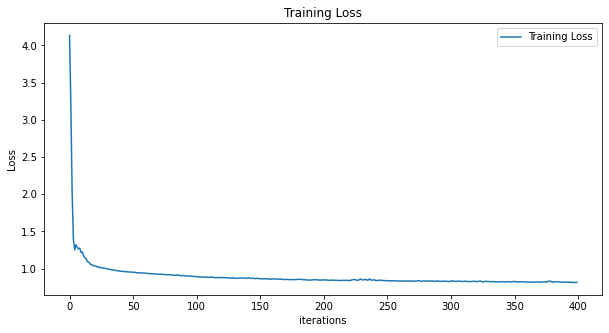

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses, label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

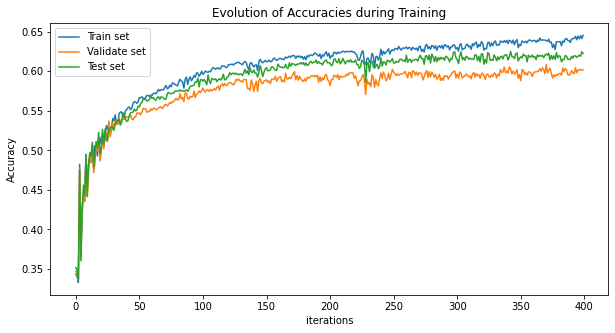

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Evolution of Accuracies during Training")
plt.plot(accuracies[0],label="Train set")
plt.plot(accuracies[1],label="Validate set")
plt.plot(accuracies[2],label="Test set")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Report

In [ ]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))

y_pred = None
y_true = None

gnn_model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = gnn_model(batch)
    y_pred = logits[batch.node_label_index].max(1)[1]
    y_true = batch.node_label

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Low', 'Middle', 'High']
print(classification_report(y_true.cpu(), y_pred.cpu(), target_names=target_names))

              precision    recall  f1-score   support

         Low       0.70      0.71      0.70      1005
      Middle       0.48      0.49      0.49       993
        High       0.68      0.67      0.68       999

    accuracy                           0.62      2997
   macro avg       0.62      0.62      0.62      2997
weighted avg       0.62      0.62      0.62      2997



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true.cpu(), y_pred.cpu())

array([[[1692,  300],
        [ 295,  710]],

       [[1486,  518],
        [ 506,  487]],

       [[1685,  313],
        [ 330,  669]]])